In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, LISAModel
from lisatools.utils.constants import *
from lisatools.sources import CalculateSNR
from lisatools.sources.emri import EMRIAETWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_8607/903449394.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


## Define mission characteristics

In [6]:
from lisatools.sensitivity import Sensitivity


class EqualArmLength1(Orbits):
    """ESA Orbits

    Orbit file: esa-trailing-orbits.h5

    """

    def __init__(self):
        # TODO: fix this up
        super().__init__("equalarmlength-orbits.h5", armlength=2.8e9)


class LISAover10A1TDISens(A1TDISens):
    @classmethod
    def get_Sn(cls, *args: Any, **kwargs: Any) -> float | np.ndarray:
        __doc__ = A1TDISens.get_Sn.__doc__
        return 1. / 10. * A1TDISens.get_Sn(*args, **kwargs)

scirdover10 = LISAModel((15.0e-12) ** 2, (3.0e-15) ** 2, EqualArmLength1(), "scirdover10")

psd_kwargs = dict(
    model=scirdover10,
    stochastic_params=(10.0 * YRSID_SI,),
)


## Diagnostics

Setup all snr calculators

In [7]:
# black hole generator
bbh = BBHSNRWaveform()

# gb generator
gb = GBAETWaveform(orbits=EqualArmLength1())

# emri generator
emri = EMRIAETWaveform()

# psd info

fn = np.logspace(-6, -1, 1000)  # for plotting
Sn = get_sensitivity(fn, sens_fn=LISAover10A1TDISens, **psd_kwargs)  # for plotting

bbh_snr_calc = CalculateSNR(bbh, psd_kwargs, psd=LISAover10A1TDISens)

emri_snr_calc = CalculateSNR(emri, psd_kwargs, psd=LISAover10A1TDISens)

gb_snr_calc = CalculateSNR(gb, psd_kwargs, psd=LISAover10A1TDISens)

Tobs = YRSID_SI
dt = 10.0
Nobs = int(Tobs / dt)
Tobs = Nobs * dt
df = 1 / Tobs


### MBHBs

In [4]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

snr_val = bbh_snr_calc(*mbh_injection_params)


5190.794652566145


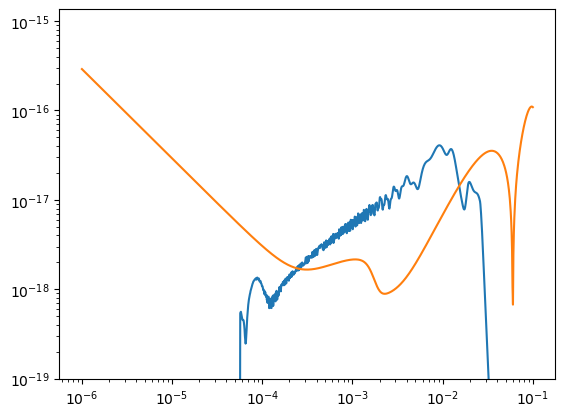

In [5]:
plt.loglog(bbh_snr_calc.f_arr, np.abs(bbh_snr_calc.last_output[0]))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))

plt.ylim(1e-19,)
print(snr_val)

### EMRIs

In [6]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)


emri_snr_val = emri_snr_calc(*emri_injection_params)



: 

142.69399276702893


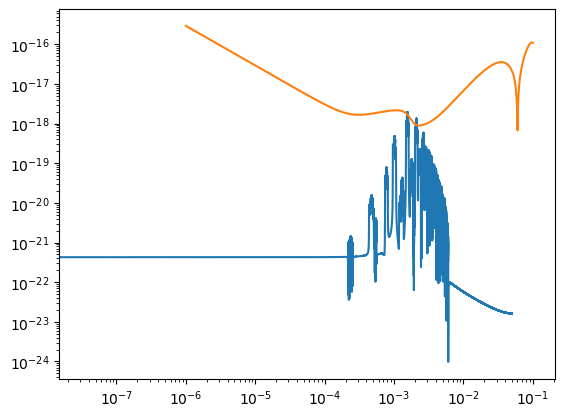

In [ ]:
freqs = np.fft.rfftfreq(emri_snr_calc.last_output[0].shape[0], dt)
plt.loglog(freqs, np.abs(np.fft.rfft(emri_snr_calc.last_output[0]) * dt))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))

print(emri_snr_val)

### GBs

In [8]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])

gb_snr_val = gb_snr_calc(*gb_injection_params)

print(gb_snr_val)

381.102730201265


In [9]:
gb_snr_calc.aet_template_gen.wave_gen.orbits.armlength

2800000000.0

(1e-06, 1.0)

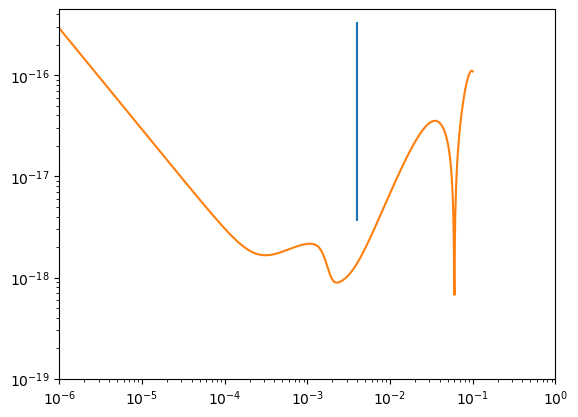

In [ ]:
plt.loglog(gb_snr_calc.f_arr, np.abs(gb_snr_calc.last_output[0]))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))

plt.ylim(1e-19,)
plt.xlim(1e-6, 1e0)

#### VGBs Specifically

In [ ]:
vgbs = pd.read_csv("vgbs.txt")

b'HPLib' 263.49230372906635 263.49230372906635
b'ZTFJ2320' 1.0874757431762427 1.0874757431762427
b'SDSSJ0923' 14.74143780461138 14.74143780461138
b'AMCVn' 522.2792962848024 522.2792962848024
b'CX1751' 18.237413419420808 18.237413419420808
b'ZTFJ2029' 16.835646357972355 16.835646357972355
b'SDSSJ0935' 226.05511296301486 226.05511296301486
b'ZTFJ1539' 273.44700866363166 273.44700866363166
b'SDSSJ2322' 103.64372608283715 103.64372608283715
b'4U1820-30' 45.5066227211539 45.5066227211539
b'HMCnc' 458.45372136585297 458.45372136585297
b'CRBoo' 69.40818860690527 69.40818860690527
b'PTFJ0533' 27.29362326600136 27.29362326600136
b'HD265435' 8.369459733226366 8.369459733226366
b'CDm30' 13.383408011177622 13.383408011177622
b'ZTFJ0640' 1.7185237394224082 1.7185237394224082
b'ZTFJ1749' 10.496923717263256 10.496923717263256
b'SMSSJ0338' 19.546456164633298 19.546456164633298
b'SDSSJ1630' 13.385206589146991 13.385206589146991
b'ZTFJ2055' 1.8525116059984752 1.8525116059984752
b'ZTFJ1901' 6.23798113837

(1e-06, 1.0)

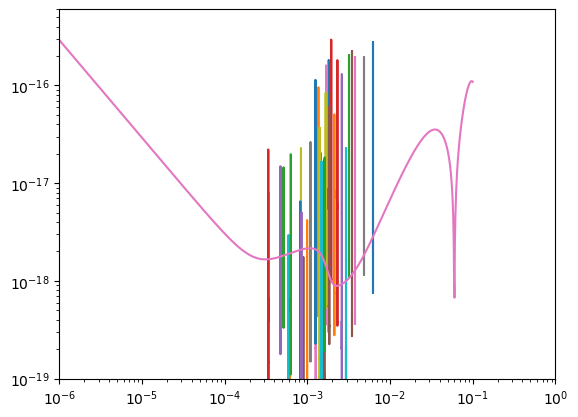

In [ ]:
for i in range(len(vgbs)):
    vgb = vgbs.iloc[i]
    params_in = np.array([
        vgb["Amplitude"],
        vgb["Frequency"],
        vgb["FrequencyDerivative"],
        0.0,
        vgb["InitialPhase"],
        vgb["Inclination"],
        vgb["Polarization"],
        vgb["EclipticLongitude"],
        vgb["EclipticLatitude"]
    ])

    snr_here = gb_snr_calc(*params_in)
    plt.loglog(gb_snr_calc.f_arr, np.abs(gb_snr_calc.last_output[0]))
    print(vgb["Name"], snr_here, snr_here)

plt.loglog(fn, (Sn / (4 * df)) ** (1/2))

plt.ylim(1e-19,)
plt.xlim(1e-6, 1e0)

In [10]:
from scipy import constants as ct

In [16]:
f = 1e-5
Mchirp = 1e6 * MSUN_SI

fdot  = 96 / 5 * np.pi ** (8/3) * (ct.G * Mchirp / ct.c** 3) ** (5/3) * f ** (11/3)
print(f, fdot)

1e-05 2.6903510925433075e-15


In [17]:
from gbgpu.utils.utility import get_fdot

In [19]:
get_fdot(1e-5, m1=1e6, m2=1e6)

2.133970465525278e-15